# Project Description

This project introduces the PressureSolver, a computational tool designed to simulate pressure distribution within a reservoir by utilizing the finite difference approach. The solver discretizes and solves the governing equations through the implementation of a tridiagonal matrix technique, enabling more accurate predictions of pressure fields. Notably, the simulated numerical model of the PressureSolver is calibrated against well test data, facilitating the prediction of essential reservoir properties such as size and permeability. Through the amalgamation of numerical simulation and real-world data calibration, this project contributes to a deeper understanding of reservoir dynamics and offers insights into reservoir characterization and management.

In [1]:
import numpy as np
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

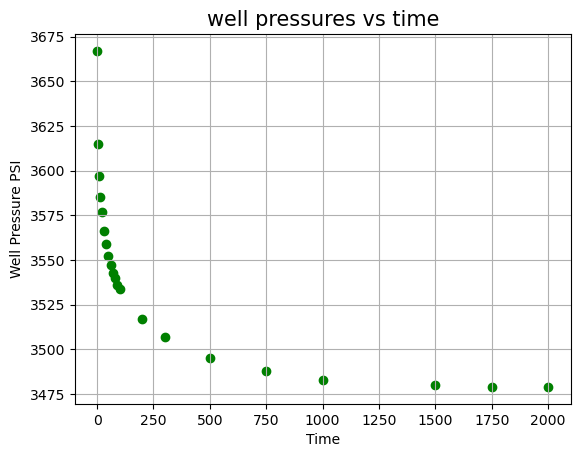

In [2]:
# Importing well test data and visualising it
df = pd.read_csv('C:/Users/donto/Downloads/nnnn/project2/data/well_bhp.dat',sep='\t')
time_data_fm=np.array(df.time)
pressure_data_fm=np.array(df.well_pressure)
plt.scatter(time_data_fm, pressure_data_fm, color="green")
plt.title('well pressures vs time', size=15)
plt.xlabel('Time')
plt.ylabel('Well Pressure PSI')
plt.grid()
plt.show()

In [3]:
def tri_diag(a, b, c):
    """Create a tridiagonal matrix."""
    return np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)

class PressureSolver:
    def __init__(self, N, dt, t_final=1, well_data="well_bhp.txt", rw=0.318, re=1000.0, h=11.0,
                 phi=0.25, mu=1.0, ct=7.8e-6, Q=1000.0, k=500, pi=3900.0):
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24. * 60. * 60.
        self.bbl_to_m3_ = 0.1589873

        self.N_ = N
        self.rw_ = rw * self.ft_to_m_
        self.re_ = re * self.ft_to_m_
        self.h_ = h * self.ft_to_m_

        self.k_ = k * 1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu * 1e-3
        self.ct_ = ct / self.psi_to_pa_

        self.Q_ = Q * self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi * self.psi_to_pa_

        self.dt_ = dt * self.day_to_sec_
        self.alpha_ = 1
        self.t_final = t_final * self.day_to_sec_
        self.well_data = well_data

        self.ye = np.log(self.re_ / self.rw_)
        self.deltay = self.ye / self.N_
        self.alpha = self.Q_ * self.mu_ / (2 * np.pi * self.h_ * self.k_)
        self.beta = self.alpha * self.deltay
        self.eta = self.k_ / (self.mu_ * self.phi_ * self.ct_)
        self.y = np.arange(self.N_) * self.deltay + self.deltay / 2

        self.xi = self.eta * np.exp(-2 * self.y) * self.dt_ / (self.rw_ ** 2 * self.deltay ** 2)

        self.a = -self.xi[1:self.N_]
        self.b = 1 + 2 * self.xi
        self.b[0] = 1 + self.xi[0]
        self.b[-1] = 1 + 3 * self.xi[-1]
        self.c = -self.xi[0:self.N_ - 1]
        self.d = np.zeros(self.N_)
        self.d[0] = self.deltay * self.alpha_

        self.A = tri_diag(self.a, self.b, self.c)

    def solve(self):
        self.pn = np.linalg.solve(self.A, self.d)

    def analytical_linesolution(self, r, t):
        return self.pi_ + (self.mu_ * self.Q_ / (4 * np.pi * self.h_ * self.k_)) * scipy.special.expi(-r**2 / (4 * self.eta * t))

    def well_pressure(self, p0):
        return p0 - self.beta / 2

    def solve_time_numerical(self):
        self.p_old = np.repeat(self.pi_, self.N_)
        self.pw_numerical = []
        self.time_numerical = []
        self.t = 0
        self.pw_numerical.append(self.well_pressure(self.p_old[0]))
        self.time_numerical.append(self.t)
        while self.t < self.t_final:
            self.d = np.zeros(self.N_)
            self.d[0] = -self.beta * self.xi[0]
            self.d[-1] = 2 * self.pi_ * self.xi[-1]
            self.d = self.d + self.p_old
            self.solve()
            self.p_old = np.copy(self.pn)
            self.t += self.dt_
            self.pw_numerical.append(self.well_pressure(self.p_old[0]))
            self.time_numerical.append(self.t)
        self.pw_numerical = np.array(self.pw_numerical)
        self.time_numerical = np.array(self.time_numerical)

    def pw_numerical_optimal(self, time, k_local, re_local):
        dt_hrs = 1
        hrs_to_sec = 60 * 60
        dt_ = dt_hrs * hrs_to_sec

        k_local = k_local * 1e-15 / 1.01325
        pi_local = self.pi_
        re_local = re_local * self.ft_to_m_
        time = time * hrs_to_sec
        pw_numerical = []
        time_numerical = []

        t = 0
        L = np.array([np.log(self.rw_ / self.rw_), np.log(re_local / self.rw_)])
        dy = L[1] / self.N_
        y = np.arange(self.N_) * dy + dy / 2

        beta_ = self.Q_ * self.mu_ * dy / (2 * np.pi * k_local * self.h_)
        nu_ = k_local / (self.mu_ * self.phi_ * self.ct_)
        xi = nu_ * np.exp(-2 * y) * dt_ / (self.rw_ ** 2 * dy ** 2)

        a = -np.delete(xi, 0)
        c = -np.delete(xi, -1)
        b = 1 + 2 * xi
        b[0] = 1 + xi[0]
        b[-1] = 1 + 3 * xi[-1]
        A = tri_diag(a, b, c)
        p_old = np.repeat(pi_local, self.N_)
        while t < max(time):
            d = np.zeros(self.N_)
            d[0] = -beta_ * xi[0]
            d[-1] = 2 * pi_local * xi[-1]
            d = d + p_old
            pn = np.linalg.solve(A, d)
            if t in time:
                well_pressure = self.well_pressure(p_old[0])
                pw_numerical.append(well_pressure)
                time_numerical.append(t)
            p_old = np.copy(pn)
            t += dt_

        if t in time:
            well_pressure = self.well_pressure(p_old[0])
            pw_numerical.append(well_pressure)
            time_numerical.append(t)
        time_numerical = np.array(time_numerical)
        pw_numerical = np.array(pw_numerical)

        return pw_numerical / self.psi_to_pa_

    def plot_2_different_well_pressure(self):
        df = pd.read_csv('C:/Users/donto/Downloads/nnnn/project2/data/well_bhp.dat',sep='\t')
        x = df.time
        y = df.well_pressure
        plt.scatter(x, y, color="red", label="Well test data")
        plt.title("Well pressure comparison: well test data, numerical")
        plt.scatter(self.time_numerical * 24 / self.day_to_sec_, self.pw_numerical / self.psi_to_pa_,
                    color="blue", label="Numerical N=" + str(self.N_))

        plt.ylabel("Well pressure, psi")
        plt.xlabel("Time - log scale, hours")
        plt.xscale("log")
        plt.grid()
        plt.legend()
        plt.show()

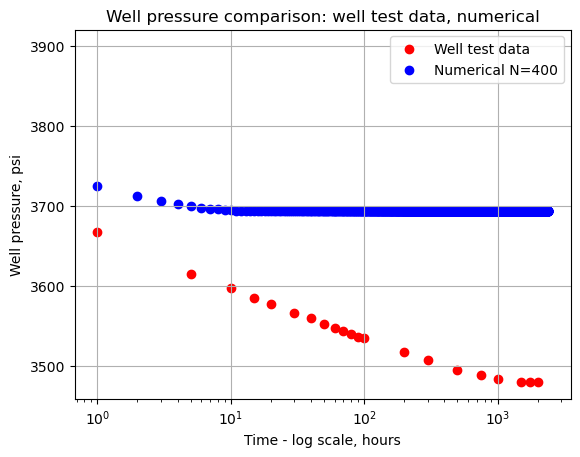

In [4]:
# Plotting comparison between well pressure and numberical model
H1=PressureSolver(N=400, t_final=100, dt=1/24)
H1.solve_time_numerical()
H1.plot_2_different_well_pressure()

In [5]:
# Determining Optimum parameter 
H1=PressureSolver(N=400, dt=1/24, t_final=100)
popt, _ = curve_fit(H1.pw_numerical_optimal, time_data_fm, pressure_data_fm)
print("Optimal parameters are k=" +str(popt[0])+" and re="+str(popt[1]))

Optimal parameters are k=325.28218368642865 and re=747864.9497671885


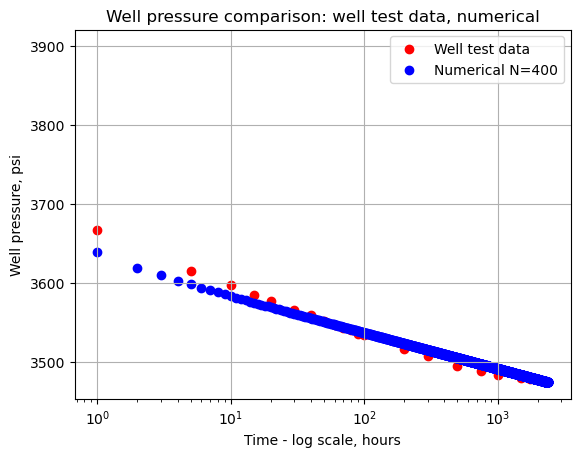

In [6]:
# Plotting optimum parameters to adjust numerical model to well data
H1=PressureSolver(N=400, k=325.28218368642865 , re=747864.9497671885, t_final=100, dt=1/24)
H1.solve_time_numerical()
H1.plot_2_different_well_pressure()

In [7]:
## Volume Computation 
# Units used for calculation is in SI
optimized_re= 747864.9497671885
rw= 0.318*0.3048
pi=3.14
h=11*0.3048
phi= 0.25

total_volume_water= (optimized_re - rw)**2 *pi*h*phi
print("Total_volume_water:", total_volume_water,"m3")

Total_volume_water: 1472053354221.9778 m3
